In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_arxiv import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.graph_sage import PositionalOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/01-1-positional_omega_graph_sage_cossim.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

## Training

In [7]:
for run in range(5):
    for n_layers in range(1, 4):
        omega = PositionalOmegaGraphSageCosSim(
            device,
            data.num_nodes,
            n_layers=n_layers,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edge_index,
                    edges_val,
                    edges_test,
                    neg_edges_val,
                    neg_edges_test,
                    edges_train_auc,
                    edges_val_auc,
                    edges_test_auc,
                    data.adj_t,
                    data.y)
        omega.discard_run_not_optimal_models()

## Results

### For a layer number

In [17]:
n_layers = 1

In [18]:
metrics = PositionalOmegaGraphSageCosSim.read_metrics(
    n_layers=n_layers,
    dataset='ogbn-arxiv'
)
print(metrics.shape)
metrics.head()

(1005, 9)


,n_layers,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,1,0,0,None,1.626177,1.626178,0.514674,0.508326,0.510777
1,1,0,1,1.6076259175180316,1.533641,1.534133,0.537439,0.546990,0.550594
2,1,0,2,1.4460307165768458,1.279960,1.280651,0.557656,0.576001,0.579608
3,1,0,3,1.1998512881331478,1.155257,1.154128,0.577115,0.594673,0.594831
4,1,0,4,1.1098758695529822,1.126072,1.123772,0.590450,0.605419,0.604430


### Sumarize metrics per epoch

In [19]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [20]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [21]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.626132,0.000042,1.626132,0.000043,0.514493,0.002568,0.507249,0.001433,0.508300,0.002894
1,1.605963,0.001503,1.524824,0.008110,1.524981,0.008286,0.540296,0.001788,0.548956,0.001899,0.553293,0.001752
2,1.432197,0.012877,1.269167,0.014396,1.268879,0.014970,0.573398,0.010059,0.592339,0.012392,0.594941,0.012034
3,1.194439,0.013106,1.160875,0.010628,1.159427,0.010333,0.598374,0.013607,0.619694,0.016537,0.618080,0.015627
4,1.113738,0.007060,1.130468,0.005720,1.128345,0.005229,0.608364,0.012068,0.628620,0.015110,0.626111,0.014161


In [22]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
44,0.767744,0.002531,0.813239,0.001885,0.811102,0.001948,0.670762,0.002981,0.690253,0.001070,0.685011,0.000707
45,0.761696,0.002596,0.807886,0.001946,0.805718,0.001977,0.670938,0.002799,0.690239,0.001188,0.685023,0.000725
51,0.727969,0.002634,0.777368,0.002131,0.774988,0.002181,0.671555,0.002051,0.690152,0.001406,0.685128,0.000950
43,0.773667,0.002446,0.818666,0.001830,0.816522,0.001939,0.670402,0.003208,0.690097,0.000913,0.684828,0.000659
50,0.733380,0.002615,0.782183,0.002094,0.779944,0.002141,0.671428,0.002010,0.690082,0.001273,0.684978,0.001006


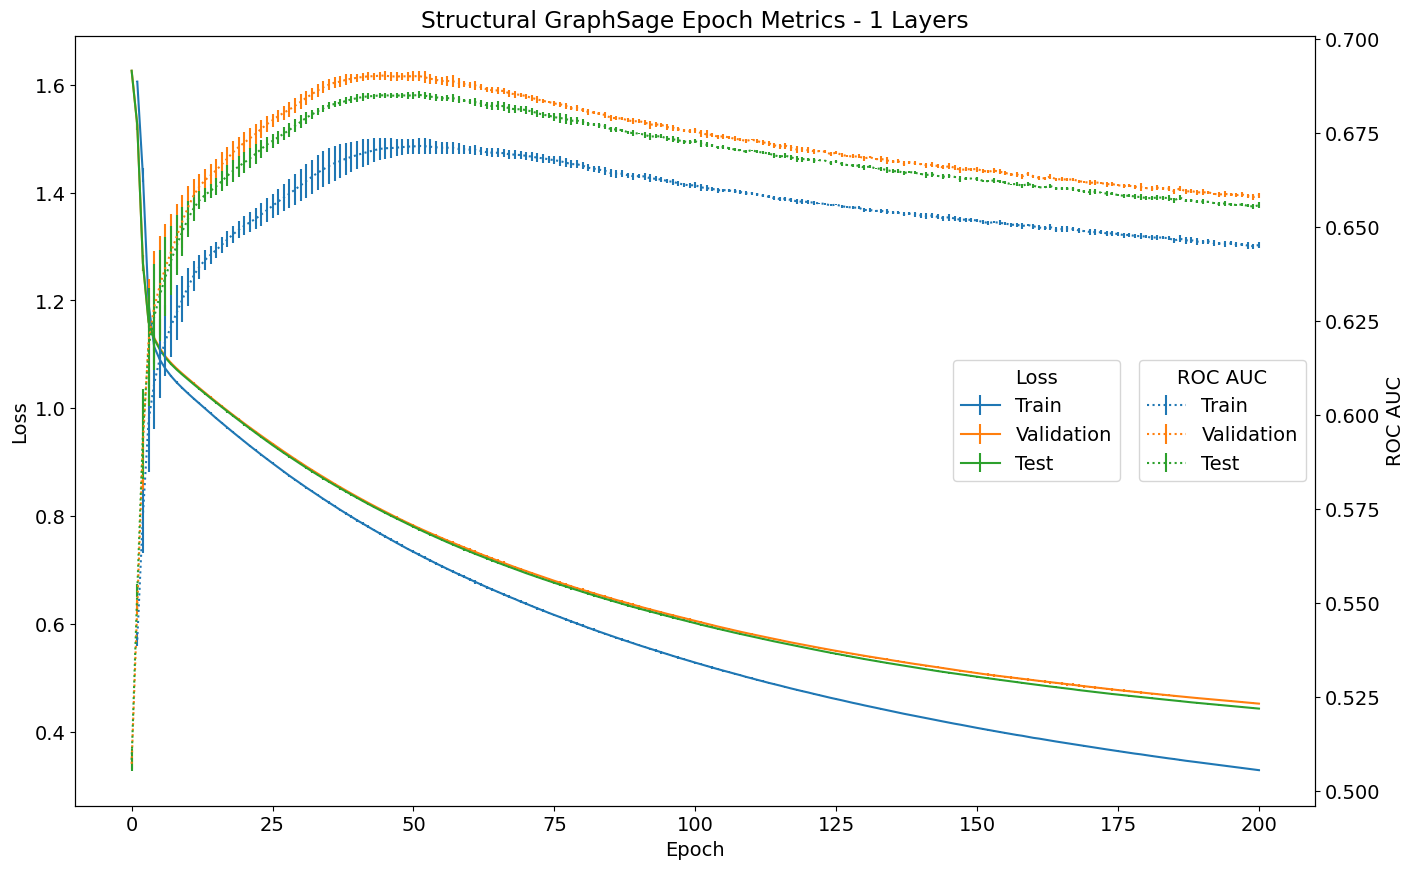

In [25]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Positional GraphSage Epoch Metrics - {n_layers} Layer')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/positional_omega_graphsage_cossim_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [13]:
n_layers_list = range(1, 4)

In [14]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = PositionalOmegaGraphSageCosSim.read_metrics(n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

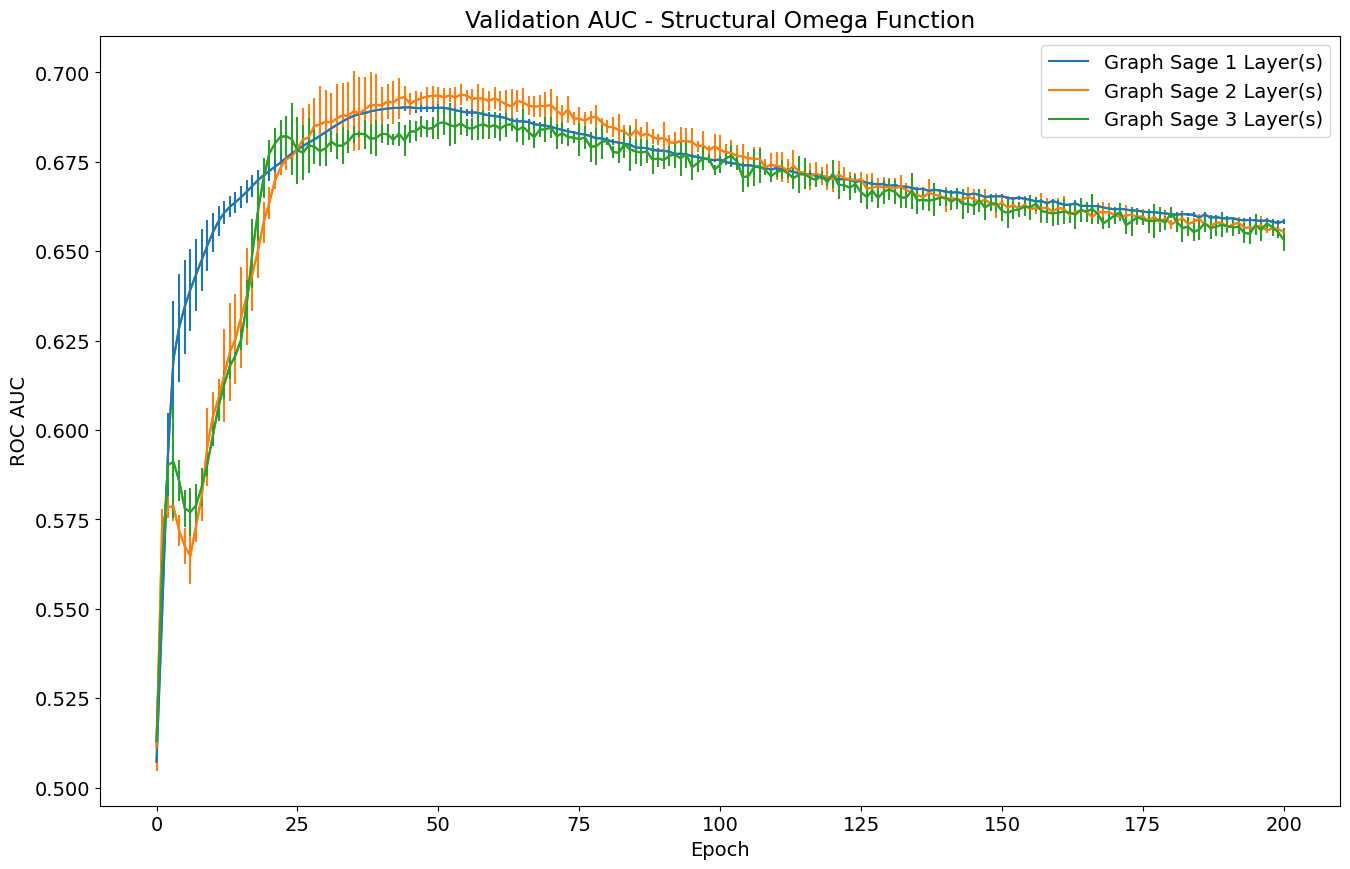

In [30]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    error_bar = ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        # label=f'Graph Sage {n_layers} Layer(s)',
    )

    color = error_bar[0].get_color()

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)',
        color=color,
    )

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

In [29]:
error_bar[0].get_color()

'#9467bd'

## Score Best model

In [30]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

n_layers                       3
run                            2
epoch                         24
loss_train    0.8826995498565914
loss_val                0.914682
loss_test               0.907354
auc_train               0.670072
auc_val                 0.695876
auc_test                 0.68282
Name: 426, dtype: object

In [31]:
best_model_metrics.to_json('models/positional_omega_graph_sage_cossim/best_model_info.json')

### Load data

In [32]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [34]:
omega = PositionalOmegaGraphSageCosSim.load_model(
    int(best_model_metrics['run']),
    int(best_model_metrics['epoch']),
    device,
    data.num_nodes,
    n_layers=int(best_model_metrics['n_layers']))

### Score model

In [37]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [38]:
preds = omega.forward(edge_index, data.adj_t).to('cpu').detach().numpy()
preds[:5]

array([[0.71652806],
       [0.7347088 ],
       [0.73586553],
       [0.7306432 ],
       [0.7338608 ]], dtype=float32)

In [39]:
theta = omega.is_same_class(edge_index, data.y).to('cpu').detach().numpy()

In [40]:
roc_auc_score(theta, preds)

0.6825537872993714

In [41]:
theta.mean()

0.6542197738985782

### Save output

In [42]:
cpu_edges = edge_index.to('cpu').numpy()
edges_gamma_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'gamma_pred': preds[:,0]
})
print(edges_gamma_df.shape)
edges_gamma_df.head()

(2315598, 3)


,source,target,gamma_pred
0,411,0,0.716528
1,640,0,0.734709
2,1162,0,0.735866
3,1897,0,0.730643
4,3396,0,0.733861


In [43]:
edges_gamma_df.to_csv('data/gamma_graph_sage/01-1_gamma_scored_edges.csv', index=False)

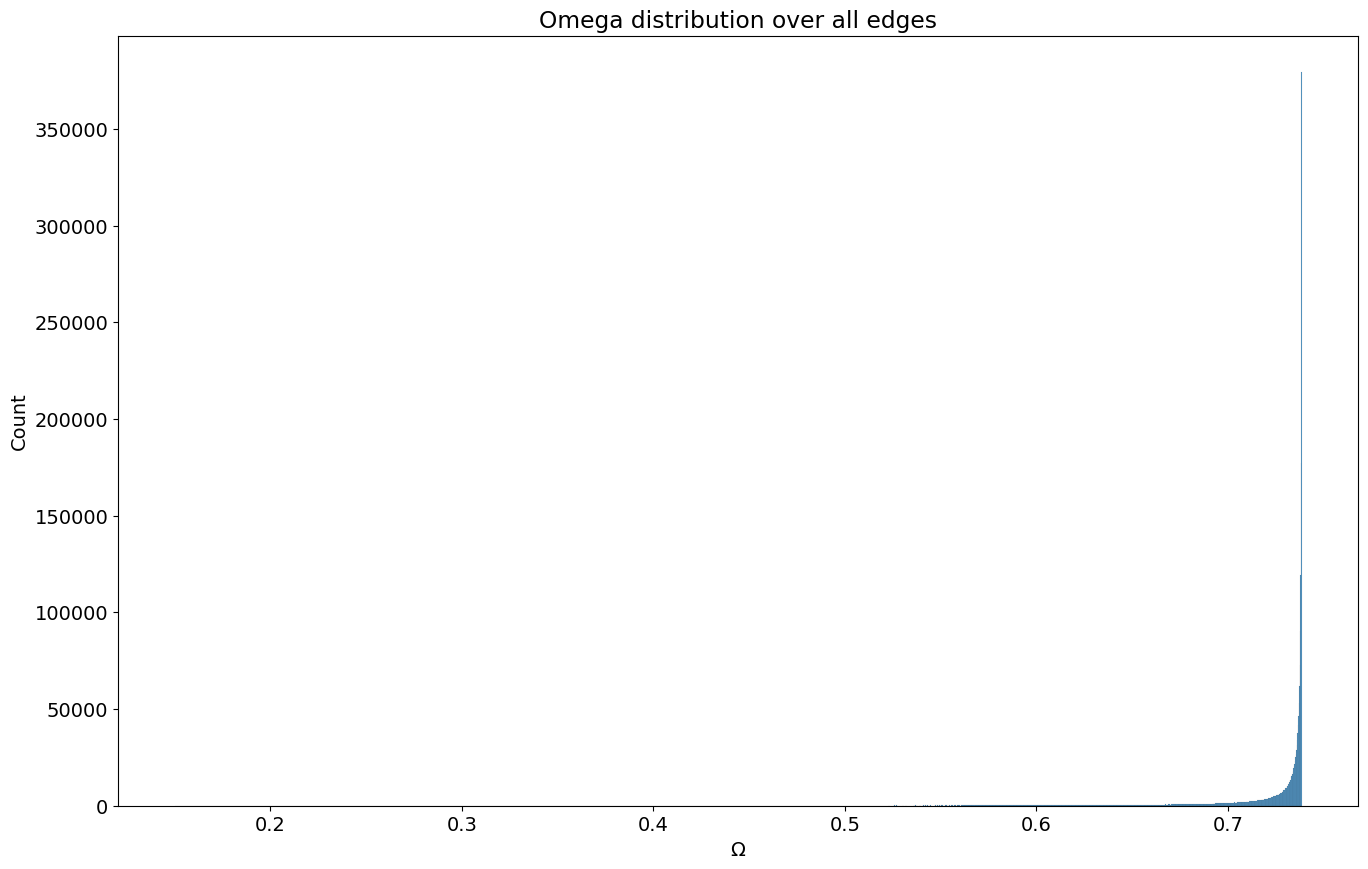

In [44]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_gamma_df['gamma_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig('reports/images/best_omega_distribution.png')

In [45]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_gamma_df['gamma_pred'].mean()],
    'Std. Dev.': [edges_gamma_df['gamma_pred'].std()],
    'Skewness': [edges_gamma_df['gamma_pred'].skew()],
    'Kurtosis': [edges_gamma_df['gamma_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.683000 & 0.716000 & 0.054000 & -4.401000 & 23.403000 \\
\end{tabular}

